In [142]:
#This project is part a series I am doing in trying to understand how sentiment on key issues rather than simple party preference can be used to understand where public opinion is. That is, rather than using % of Dems are favorable/unfavorable to policy x, find if there are ways to cluster people to get a sense of a type of person and how that person will approach policy x. The model will use KMeans clustering in order to identify three clusters of people. These clusters will be based upon how people feel about Trump himself as well as the direction of the country and party leadership in congress. I will use data from Pew Research Institute from March 2019. I begin by isolating just the responses to the four questions I will use to determine the clusters. I then have to map answers given as strings to intergers in order to cluster the results. I then use a KMeans classifier to determine three clusters (three because I want to explore the viability of liberal, convservative, and actual indendents). Interesting, there are several instances where the model gets a purer result than simply breaking people by party preference. After looking at the results, my sense is that there are people who do not identify as Dem or GOP but who will likely vote for one of the two major parties because of where they align on issues. The trick is being able to speak beyond a party's base.

#This project will utilize unsupervised machine learning to develop labels from an unlabeled dataset. 

In [143]:
import savReaderWriter 
import numpy as np
import pandas as pd

#reader_np = savReaderWriter.SavReaderNp("Mar19 public.sav")
#array = reader_np.to_structured_array("outfile.dat") 
#np.savetxt("outfile2.csv", array, delimiter=",")
#reader_np.close()

df = pd.read_spss('Mar19 public.sav')
df.to_csv("Mar19 public.csv", encoding = "utf-8-sig")

In [144]:
data = pd.read_csv('Mar19 public.csv')
print(data.head())

   Unnamed: 0  respid    sample  int_date     fcall  attempt refusal     lang  \
0           0     2.0  Landline  190320.0  190320.0      1.0      No  English   
1           1     3.0  Landline  190320.0  190320.0      1.0      No  English   
2           2     4.0  Landline  190320.0  190320.0      1.0      No  English   
3           3     5.0  Landline  190320.0  190320.0      1.0      No  English   
4           4     6.0  Landline  190320.0  190320.0      1.0      No  English   

     cregion state  ...  hh1  hh3     adults                   ql1 ql1a  qc1  \
0  Northeast    NY  ...  2.0  2.0          2  Yes, have cell phone  NaN  NaN   
1  Northeast    PA  ...  1.0  NaN          1            No, do not  NaN  NaN   
2      South    FL  ...  2.0  2.0          2  Yes, have cell phone  NaN  NaN   
3      South    NC  ...  2.0  2.0          2  Yes, have cell phone  NaN  NaN   
4    Midwest    MI  ...  4.0  3.0  3 or more  Yes, have cell phone  NaN  NaN   

         ll            cp money2

In [145]:
#print(data.iloc[1])
print(data.columns)
print(data['q2'].value_counts())
print(data['q1'].value_counts())

Index(['Unnamed: 0', 'respid', 'sample', 'int_date', 'fcall', 'attempt',
       'refusal', 'lang', 'cregion', 'state',
       ...
       'hh1', 'hh3', 'adults', 'ql1', 'ql1a', 'qc1', 'll', 'cp', 'money2',
       'weight'],
      dtype='object', length=130)
Disapprove                  792
Approve                     639
(VOL) Don't know/Refused     72
Name: q2, dtype: int64
Dissatisfied                930
Satisfied                   489
(VOL) Don't know/Refused     84
Name: q1, dtype: int64


In [146]:
#q10af1 asks about approve/dissaprove GOP leaders in congress; q10bf1 asks about Dem leaders in congress. I'm also going to check to make sure that each interviewee received both questions.
print(data['q10af1'].value_counts())
print(data['q10bf1'].value_counts())
print(data.iloc[5].q10af1)
print(data.iloc[5].q10bf1)


Disapprove                  479
Approve                     227
(VOL) Don't know/Refused     45
Name: q10af1, dtype: int64
Disapprove                  457
Approve                     238
(VOL) Don't know/Refused     56
Name: q10bf1, dtype: int64
Approve
Disapprove


In [147]:
#Let's see if we can get clusters using opinions on Trump and leaders in Congress and the direction of the country. q1 is about the country with Sat/Dis/DK. q2 is about trump with App/Dis/DK. I need to map these responses to intergers before clustering.

data_clust = data[['q1', 'q2', 'q10af1', 'q10bf1']]
data_clust['q1'] = data_clust['q1'].map({'Satisfied':0, 'Dissatisfied':1, '(VOL) Don\'t know/Refused':2})
data_clust['q2'] = data_clust['q2'].map({'Approve':0, 'Disapprove':1, '(VOL) Don\'t know/Refused':2})
data_clust['q10af1'] = data_clust['q10af1'].map({'Approve':0, 'Disapprove':1, '(VOL) Don\'t know/Refused':2})
data_clust['q10bf1'] = data_clust['q10af1'].map({'Approve':1, 'Disapprove':0, '(VOL) Don\'t know/Refused':2})
questions = ['q1', 'q2', 'q10af1', 'q10bf1']
for i in questions:
    data_clust[i] = data_clust[i].fillna(3)

In [148]:
# Here we see that the mapping worked and the strings (e.g., Approve) have been mapped to intergers which will allow me to use the KMeans classifier.
print(data_clust.value_counts())

q1  q2  q10af1  q10bf1
1   1   3.0     3.0       341
        1.0     3.0       311
0   0   3.0     3.0       189
        0.0     3.0       117
1   0   3.0     3.0       110
0   0   1.0     3.0        59
1   0   1.0     3.0        56
        0.0     3.0        53
0   1   3.0     3.0        50
2   1   3.0     3.0        20
0   1   1.0     3.0        20
2   0   3.0     3.0        16
        0.0     3.0        16
1   1   0.0     3.0        14
0   1   0.0     3.0        13
1   2   1.0     3.0        12
        3.0     3.0        11
0   0   2.0     3.0        11
2   1   1.0     3.0         8
0   2   3.0     3.0         8
1   1   2.0     3.0         7
0   2   1.0     3.0         7
        0.0     3.0         7
2   2   3.0     3.0         7
    0   1.0     3.0         5
1   0   2.0     3.0         5
    2   2.0     3.0         5
        0.0     3.0         5
2   2   2.0     3.0         5
0   2   2.0     3.0         4
    1   2.0     3.0         4
2   1   0.0     3.0         2
        2.0     3

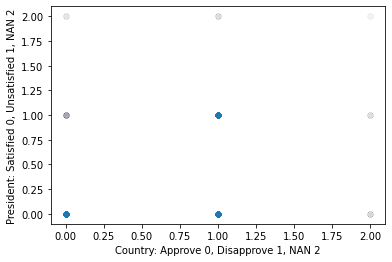

,q1,q2,q10af1,q10bf1
0,1,1,3.0,3.0
1,1,1,3.0,3.0
2,2,0,0.0,3.0
3,0,0,3.0,3.0
4,1,1,3.0,3.0
...,...,...,...,...
1498,1,1,3.0,3.0
1499,1,2,1.0,3.0
1500,1,1,3.0,3.0
1501,0,0,3.0,3.0


In [172]:
from matplotlib import pyplot as plt
plt.subplot()
plt.scatter(data_clust['q1'], data_clust['q2'], alpha=.005)
plt.xlabel('Country: Approve 0, Disapprove 1, NAN 2')
plt.ylabel('President: Satisfied 0, Unsatisfied 1, NAN 2')
plt.show()
data_clust

In [151]:
from sklearn.cluster import KMeans
classifier = KMeans(n_clusters = 3)

classifier.fit(data_clust)
print(classifier.cluster_centers_)

[[0.44904459 0.04140127 0.36624204 3.        ]
 [0.71963824 0.60335917 2.97157623 3.        ]
 [0.96385542 1.09879518 0.98795181 3.        ]]


In [152]:
print(classifier.labels_)
cluster_zero = []
cluster_one = []
cluster_two = []

for i in range(len(classifier.labels_)):
    if classifier.labels_[i] == 0:
        cluster_zero.append(i)
    elif classifier.labels_[i] == 1:
        cluster_one.append(i)
    else:
        cluster_two.append(i)

#cluster_zero

[1 1 0 ... 1 1 2]


In [153]:
data_zero = data.iloc[cluster_zero]
data_one = data.iloc[cluster_one]
data_two = data.iloc[cluster_two]

In [154]:
print(data_one['q14f2'].value_counts())

Disapprove                  364
Approve                     303
(VOL) Don't know/Refused     85
Name: q14f2, dtype: int64


In [155]:
print(data_zero['q14f2'].value_counts())
print(cluster_zero[0:5])
print(data.iloc[2]['q14f2'])
print(data.iloc[17]['q14f2'])

Series([], Name: q14f2, dtype: int64)
[2, 5, 6, 7, 17]
nan
nan


In [156]:
print(data_two['q14f2'].value_counts())
print(cluster_two[0:5])
print(data.iloc[8]['q14f2'])
print(data.iloc[16]['q14f2'])

Series([], Name: q14f2, dtype: int64)
[8, 9, 14, 16, 18]
nan
nan


In [157]:
print(data_zero['q20'].value_counts())
print(data_one['q20'].value_counts())
print(data_two['q20'].value_counts())

Frustrated                  181
Basically content            71
Angry                        56
(VOL) Don't know/Refused      6
Name: q20, dtype: int64
Frustrated                  438
Angry                       163
Basically content           148
(VOL) Don't know/Refused     25
Name: q20, dtype: int64
Frustrated                  256
Angry                        98
Basically content            42
(VOL) Don't know/Refused     19
Name: q20, dtype: int64


In [158]:
# q33af1 asks about the interviewee's impression of Trump. The fact that the data shows such significant correlations in one direction seems to indicate that cluster_zero has grouped people strongly favorable to Trump, cluster_two has grouped people strongly opposed, and cluster_one has grouped people with less polarized opinions.
print(data_zero['q33af1'].value_counts()/len(data_zero)*100)
print(data_one['q33af1'].value_counts()/len(data_one)*100)
print(data_two['q33af1'].value_counts()/len(data_two)*100)

Trustworthy                   79.936306
Not trustworthy               17.834395
(VOL) Neither particularly     1.273885
(VOL) Don't know/Refused       0.955414
Name: q33af1, dtype: float64
Trustworthy                   1.808786
Not trustworthy               0.775194
(VOL) Neither particularly    0.258398
Name: q33af1, dtype: float64
Not trustworthy               93.253012
Trustworthy                    4.578313
(VOL) Don't know/Refused       1.686747
(VOL) Neither particularly     0.481928
Name: q33af1, dtype: float64


In [159]:
# I want to see how these clusters respond to q44af1 which asks about funding for health care. The results seem to fit expectations. Those opposed to Trump will be more favorable to increasing spending on healthcare while favorable to him largely, although not with the same energy as data_two is in favor of increasing, do not.
print(data_zero['q44af1'].value_counts()/len(data_zero)*100)
print(data_one['q44af1'].value_counts()/len(data_one)*100)
print(data_two['q44af1'].value_counts()/len(data_two)*100)

Keep spending the same      38.216561
Decrease spending           30.891720
Increase spending           26.114650
(VOL) Don't know/Refused     4.777070
Name: q44af1, dtype: float64
Decrease spending           1.291990
Keep spending the same      1.033592
Increase spending           0.516796
(VOL) Don't know/Refused    0.129199
Name: q44af1, dtype: float64
Increase spending           68.674699
Keep spending the same      19.759036
Decrease spending            7.228916
(VOL) Don't know/Refused     4.337349
Name: q44af1, dtype: float64


In [160]:
# q44nf2 is on education spending
print(data_zero['q44nf2'].value_counts()/len(data_zero)*100)
print(data_one['q44nf2'].value_counts()/len(data_one)*100)
print(data_two['q44nf2'].value_counts()/len(data_two)*100)


Series([], Name: q44nf2, dtype: float64)
Increase spending           61.757106
Keep spending the same      18.604651
Decrease spending            9.302326
(VOL) Don't know/Refused     1.162791
Name: q44nf2, dtype: float64
Series([], Name: q44nf2, dtype: float64)


In [161]:
print(data_zero['q47'].value_counts()/len(data_zero)*100)
print(data_one['q47'].value_counts()/len(data_one)*100)
print(data_two['q47'].value_counts()/len(data_two)*100)

No, not keeping promises    69.108280
Yes, keeping promises       22.929936
(VOL) Don't know/Refused     7.961783
Name: q47, dtype: float64
No, not keeping promises    44.961240
Yes, keeping promises       41.860465
(VOL) Don't know/Refused    13.178295
Name: q47, dtype: float64
Yes, keeping promises       53.493976
No, not keeping promises    30.602410
(VOL) Don't know/Refused    15.903614
Name: q47, dtype: float64


In [162]:
print(data_zero['q55f1'].value_counts()/len(data_zero)*100)
print(data_one['q55f1'].value_counts()/len(data_one)*100)
print(data_two['q55f1'].value_counts()/len(data_two)*100)

Smaller government, fewer services    77.070064
Bigger government, more services      19.745223
(VOL) Depends                          2.229299
(VOL) Don't know/Refused               0.955414
Name: q55f1, dtype: float64
Smaller government, fewer services    2.067183
Bigger government, more services      0.645995
(VOL) Depends                         0.129199
Name: q55f1, dtype: float64
Bigger government, more services      60.481928
Smaller government, fewer services    32.530120
(VOL) Depends                          4.096386
(VOL) Don't know/Refused               2.891566
Name: q55f1, dtype: float64


In [163]:
#66a and 66b ask about feelings towards Dem and Repub parties, respectively. 

print(data_zero['q68a'].value_counts()/len(data_zero)*100)
print(data_one['q68a'].value_counts()/len(data_one)*100)
print(data_two['q68a'].value_counts()/len(data_two)*100)

print('BREAK')

print(data_zero['q68b'].value_counts()/len(data_zero)*100)
print(data_one['q68b'].value_counts()/len(data_one)*100)
print(data_two['q68b'].value_counts()/len(data_two)*100)


Unfriendly toward religion    65.923567
Neutral toward religion       22.292994
Friendly toward religion      10.191083
(VOL) Don't know/Refused       1.592357
Name: q68a, dtype: float64
Neutral toward religion       38.113695
Unfriendly toward religion    32.687339
Friendly toward religion      25.193798
(VOL) Don't know/Refused       4.005168
Name: q68a, dtype: float64
Neutral toward religion       50.120482
Friendly toward religion      33.012048
Unfriendly toward religion    12.289157
(VOL) Don't know/Refused       4.578313
Name: q68a, dtype: float64
BREAK
Friendly toward religion      62.420382
Neutral toward religion       30.254777
Unfriendly toward religion     5.414013
(VOL) Don't know/Refused       1.910828
Name: q68b, dtype: float64
Friendly toward religion      54.521964
Neutral toward religion       28.036176
Unfriendly toward religion    13.436693
(VOL) Don't know/Refused       4.005168
Name: q68b, dtype: float64
Friendly toward religion      47.710843
Neutral toward reli

In [164]:
print(data_zero['q69'].value_counts()/len(data_zero)*100)
print(data_one['q69'].value_counts()/len(data_one)*100)
print(data_two['q69'].value_counts()/len(data_two)*100)

Should keep out of political matters                                       50.000000
Should express their views on day-to-day social and political questions    48.407643
(VOL) Don't know/Refused                                                    1.592357
Name: q69, dtype: float64
Should keep out of political matters                                       56.589147
Should express their views on day-to-day social and political questions    39.147287
(VOL) Don't know/Refused                                                    4.263566
Name: q69, dtype: float64
Should keep out of political matters                                       59.277108
Should express their views on day-to-day social and political questions    37.349398
(VOL) Don't know/Refused                                                    3.373494
Name: q69, dtype: float64


In [165]:
print(data_zero['party'].value_counts()/len(data_zero)*100)
print(data_one['party'].value_counts()/len(data_one)*100)
print(data_two['party'].value_counts()/len(data_two)*100)

Republican                  55.095541
Independent                 33.757962
Democrat                     5.732484
(VOL) No preference          2.229299
(VOL) Other party            1.592357
(VOL) Don't know/Refused     1.592357
Name: party, dtype: float64
Independent                 36.563307
Republican                  30.232558
Democrat                    28.165375
(VOL) No preference          2.325581
(VOL) Don't know/Refused     2.196382
(VOL) Other party            0.516796
Name: party, dtype: float64
Democrat                    45.542169
Independent                 42.650602
Republican                   4.096386
(VOL) No preference          3.855422
(VOL) Don't know/Refused     3.132530
(VOL) Other party            0.722892
Name: party, dtype: float64


In [166]:
questions=['qs1', 'q1', 'q2', 'q10af1', 'q10bf1', 'q14f2',
'q19', 'q20', 'q25', 'q33af1', 'q33bf1', 'q33cf1', 'q33df1', 'q33ff2',
'q33gf2', 'q33hf2', 'q33if2', 'q33jf2', 'q34f1', 'q44af1', 'q44bf1', 'q44cf1', 'q44ef1', 'q44ff1', 'q44gf1', 'q44hf2', 'q44if2', 'q44jf2', 'q44kf2', 'q44lf2', 'q44mf2', 'q44nf2', 'q47',  'q48f1', 'q49f2', 'q50a', 'q50b', 'q50c', 'q50d', 'q50a', 'q50b', 'q50c', 'q50d', 'q50e','q50ff1', 'q54f2', 'q55f1', 'q56f2', 'q57f2', 'q58', 'q60', 'q61a', 'q61b', 'q61c', 'q61df1', 'q61ef1', 'q61ff2', 'q61gf2', 'q61hf2', 'q61if1', 'q64', 'q65a', 'q65b', 'q65c', 'q65d', 'q65e', 'q66', 'q67', 'q68a', 'q68b', 'q68d', 'q69', 'q70', 'q70a', 'q71', 'q75', 'q76f1', 'q77f2', 'qi1', 'sex', 'age', 'educ', 'hisp', 'racecmb', 'racethn', 'birth_hisp', 'relig', 'chr', 'qf2', 'born', 'attend', 'income', 'reg','party', 'partyln', 'partysum', 'ideo', 'partyideo', 'partysumideo', 'hh1', 'hh3', 'adults', 'ql1', 'ql1a', 'qc1', 'll', 'cp', 'money2', 'weight']


In [167]:
for i in questions:
    print("In response to question " + i)
    print('GROUP ZERO - More Indendent 36%')
    print(data_zero[i].value_counts()/len(data_zero)*100)
    print('GROUP ONE - More GOP 55%')
    print(data_one[i].value_counts()/len(data_one)*100)
    print('GROUP TWO - More Dem 45%')
    print(data_two[i].value_counts()/len(data_two)*100)


In response to question qs1
GROUP ZERO - More Indendent 36%
18 or older    78.66242
Name: qs1, dtype: float64
GROUP ONE - More GOP 55%
18 or older    80.103359
Name: qs1, dtype: float64
GROUP TWO - More Dem 45%
18 or older    80.963855
Name: qs1, dtype: float64
In response to question q1
GROUP ZERO - More Indendent 36%
Satisfied                   60.191083
Dissatisfied                34.713376
(VOL) Don't know/Refused     5.095541
Name: q1, dtype: float64
GROUP ONE - More GOP 55%
Dissatisfied                60.335917
Satisfied                   33.850129
(VOL) Don't know/Refused     5.813953
Name: q1, dtype: float64
GROUP TWO - More Dem 45%
Dissatisfied                85.301205
Satisfied                    9.156627
(VOL) Don't know/Refused     5.542169
Name: q1, dtype: float64
In response to question q2
GROUP ZERO - More Indendent 36%
Approve       95.859873
Disapprove     4.140127
Name: q2, dtype: float64
GROUP ONE - More GOP 55%
Disapprove                  53.617571
Approve          

In [168]:
#Now I want to see how these numbers compare to simply grouping by party. I'll start with Dem, Repub, and Ind.
party = data['party']
dem = []
gop = []
ind = []
for i in range(len(party)):
    if party[i] == 'Democrat':
        dem.append(i)
    elif party[i] == 'Republican':
        gop.append(i)
    elif party[i] == 'Independent':
        ind.append(i)
dem_data = data.iloc[dem]
gop_data = data.iloc[gop]
ind_data = data.iloc[ind]

In [169]:
print(dem_data['party'].value_counts()/len(dem_data)*100)
print(gop_data['party'].value_counts()/len(gop_data)*100)
print(ind_data['party'].value_counts()/len(ind_data)*100)

Democrat    100.0
Name: party, dtype: float64
Republican    100.0
Name: party, dtype: float64
Independent    100.0
Name: party, dtype: float64


In [170]:
print(dem_data['q2'].value_counts()/len(dem_data)*100)
print(gop_data['q2'].value_counts()/len(gop_data)*100)
print(ind_data['q2'].value_counts()/len(ind_data)*100)

print('!!!!!! BREAK !!!!!!!')

print(data_zero['q2'].value_counts()/len(data_zero)*100)
print(data_one['q2'].value_counts()/len(data_one)*100)
print(data_two['q2'].value_counts()/len(data_two)*100)

Disapprove                  90.117647
Approve                      7.058824
(VOL) Don't know/Refused     2.823529
Name: q2, dtype: float64
Approve                     85.849057
Disapprove                  11.556604
(VOL) Don't know/Refused     2.594340
Name: q2, dtype: float64
Disapprove                  57.067138
Approve                     36.219081
(VOL) Don't know/Refused     6.713781
Name: q2, dtype: float64
!!!!!! BREAK !!!!!!!
Approve       95.859873
Disapprove     4.140127
Name: q2, dtype: float64
Disapprove                  53.617571
Approve                     43.023256
(VOL) Don't know/Refused     3.359173
Name: q2, dtype: float64
Disapprove                  87.710843
(VOL) Don't know/Refused    11.084337
Approve                      1.204819
Name: q2, dtype: float64


In [171]:
# healthcare q44af1
print(dem_data['q44af1'].value_counts()/len(dem_data)*100)
print(gop_data['q44af1'].value_counts()/len(gop_data)*100)
print(ind_data['q44af1'].value_counts()/len(ind_data)*100)

Increase spending           37.176471
Keep spending the same       9.647059
Decrease spending            1.647059
(VOL) Don't know/Refused     0.705882
Name: q44af1, dtype: float64
Keep spending the same      18.632075
Decrease spending           14.858491
Increase spending           10.613208
(VOL) Don't know/Refused     3.301887
Name: q44af1, dtype: float64
Increase spending           25.441696
Keep spending the same      13.957597
Decrease spending            9.893993
(VOL) Don't know/Refused     2.296820
Name: q44af1, dtype: float64
